In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pickle
import os, sys
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from matplotlib.colors import ListedColormap, BoundaryNorm


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan.plots import plot_precip, plot_contourf
from dsrnngan.data import denormalise, DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh

In [5]:
# model_number = 230400
# model_number = 160000
model_number = 153600

model_type = 'cropped'

log_folders = {'basic': '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201806-201905_e50',
               'full_image': '/user/work/uz22147/logs/cgan/43ae7be47e9a182e_full_image/n1000_201806-201905_e50',
               'cropped': '/user/work/uz22147/logs/cgan/ff62fde11969a16f/n2000_201806-201905_e20'}

log_folder = log_folders[model_type]
with open(os.path.join(log_folder, f'arrays-{model_number}.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)
    
truth_array = arrays['truth']
samples_gen_array = arrays['samples_gen']
fcst_array = arrays['fcst_array']
ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
dates = [d[0] for d in arrays['dates']]
hours = [h[0] for h in arrays['hours']]

assert len(set(list(zip(dates, hours)))) == fcst_array.shape[0], "Degenerate date/hour combinations"
(n_samples, width, height, ensemble_size) = samples_gen_array.shape


In [6]:
from dsrnngan.utils import load_yaml_file
# Get lat/lon range from log folder
base_folder = '/'.join(log_folder.split('/')[:-1])
config = load_yaml_file(os.path.join(base_folder, 'setup_params.yaml'))

# Locations
min_latitude = config['DATA']['min_latitude']
max_latitude = config['DATA']['max_latitude']
latitude_step_size = config['DATA']['latitude_step_size']
min_longitude = config['DATA']['min_longitude']
max_longitude = config['DATA']['max_longitude']
longitude_step_size = config['DATA']['longitude_step_size']
latitude_range=np.arange(min_latitude, max_latitude, latitude_step_size)
longitude_range=np.arange(min_longitude, max_longitude, longitude_step_size)


# Quantiles
step_size = 0.001
range_dict = {0: {'start': 0.1, 'stop': 1, 'interval': 0.1, 'marker': '+', 'marker_size': 32},
              1: {'start': 1, 'stop': 10, 'interval': 1, 'marker': '+', 'marker_size': 256},
              2: {'start': 10, 'stop': 80, 'interval':10, 'marker': '+', 'marker_size': 512},
              3: {'start': 80, 'stop': 99.1, 'interval': 1, 'marker': '+', 'marker_size': 256},
              4: {'start': 99.1, 'stop': 99.91, 'interval': 0.1, 'marker': '+', 'marker_size': 128},
              5: {'start': 99.9, 'stop': 99.99, 'interval': 0.01, 'marker': '+', 'marker_size': 32 },
              6: {'start': 99.99, 'stop': 99.999, 'interval': 0.001, 'marker': '+', 'marker_size': 10}}
                  
percentiles_list= [np.arange(item['start'], item['stop'], item['interval']) for item in range_dict.values()]
percentiles=np.concatenate(percentiles_list)
quantile_locs = [np.round(item / 100.0, 6) for item in percentiles]

## Data collection

In [17]:
from dsrnngan.data import denormalise

with open('/user/home/uz22147/repos/downscaling-cgan/201603_201803_2000_arrays.pkl', 'rb') as ifh:
    training_data = pickle.load(ifh)
    
imerg_train_data = denormalise(training_data['obs'])
ifs_train_data = denormalise(training_data['fcst_array'])

training_dates = [item[0] for item in training_data['dates']]
training_hours = [item[0] for item in training_data['hours']]

In [23]:
# split into train and validation

from sklearn.model_selection import StratifiedKFold

X = ifs_train_data.copy().reshape(ifs_train_data.shape[0], -1)
y = imerg_train_data.reshape(ifs_train_data.shape[0], -1)
months = [d.month for d in training_dates]

skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, months)

(train_index, val_index) = skf.split(X, months).__next__()

ifs_quantile_training_data = ifs_train_data[train_index, :, :]
imerg_quantile_training_data = imerg_train_data[train_index, :, :]

ifs_quantile_val_data = ifs_train_data[val_index, :, :]
imerg_quantile_val_data = imerg_train_data[val_index, :, :]

quantile_training_dates = np.array(training_dates)[train_index]
quantile_val_dates = np.array(training_dates)[val_index]
quantile_training_hours = np.array(training_hours)[train_index]
quantile_val_hours = np.array(training_hours)[val_index]

In [92]:
import xarray as xr

all_imerg_data = []
all_ifs_data = []

for year in tqdm(range(2003, 2018)):
    for month in range(1,13):

        imerg_ds = xr.open_dataarray(f'/user/home/uz22147/repos/rainfall_data/daily_imerg_rainfall_{month}_{year}.nc')

        imerg_data = imerg_ds.sel(lat=latitude_range, method='nearest').sel(lon=longitude_range, method='nearest').values

        for t in range(imerg_data.shape[0]):
            
            snapshot = imerg_data[t, :, :]
            
            all_imerg_data.append(snapshot)
            
all_imerg_data = np.stack(all_imerg_data, axis = 0)

daily_historical_avg = np.mean(all_imerg_data, axis=0)
daily_historical_std = np.std(all_imerg_data, axis=0)

hourly_historical_avg = daily_historical_avg / 24
hourly_historical_std = daily_historical_std / 24

100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


## Quantile mapping by pixel

In [37]:
# quantile mapping by month, pixel-by-pixel

month_ranges = [[1,2], [3,4,5], [6,7,8,9], [10,11,12]]

date_hour_list = list(zip(quantile_training_dates, quantile_training_hours))
date_hour_list_val = list(zip(quantile_val_dates, quantile_val_hours))

date_chunks =  {'_'.join([str(month_range[0]), str(month_range[-1])]): [item for item in date_hour_list if item[0].month in month_range] for month_range in month_ranges}
date_indexes =  {k : [date_hour_list.index(item) for item in chunk] for k, chunk in date_chunks.items()}

date_chunks_val =  {'_'.join([str(month_range[0]), str(month_range[-1])]): [item for item in date_hour_list_val if item[0].month in month_range] for month_range in month_ranges}
date_indexes_val =  {k : [date_hour_list_val.index(item) for item in chunk] for k, chunk in date_chunks_val.items()}

quantiles_by_month_range = {}

fcst_corrected_single_pixel = np.empty(ifs_quantile_val_data.shape)
fcst_corrected_single_pixel[:,:,:] = np.nan

for t_name, d in tqdm(date_indexes.items(), total=len(month_ranges)):
    fcst = ifs_quantile_training_data[d, :, :]
    obs = imerg_quantile_training_data[d, :, :]
    
    quantiles_by_month_range[t_name] = {'fcst': np.quantile(fcst, quantile_locs, axis=0), 'obs': np.quantile(obs,  quantile_locs, axis=0)}
    
    # Correct the forecast in the validation set using these quantiles
    d_val = date_indexes_val[t_name]
    fcst_val = ifs_quantile_val_data[d_val, :, :]
    obs_val = imerg_quantile_val_data[d_val, :, :]
    
    (n_val_samples, x_vals, y_vals) = fcst_val.shape
    
    for x in range(x_vals):
        for y in range(y_vals):
            fcst_corrected_single_pixel[d_val, x, y] = np.interp(fcst_val[:, x, y], 
                                                                 quantiles_by_month_range[t_name]['fcst'][:, x, y], 
                                                                 quantiles_by_month_range[t_name]['obs'][:, x, y])

100%|██████████| 4/4 [00:24<00:00,  6.24s/it]


In [6]:
# Analyse difference in quantiles between training set and 2018 / 2019 dat

ifs_training_quantiles = np.quantile(ifs_train_data.flatten(), quantile_locs)
imerg_training_quantiles = np.quantile(imerg_train_data.flatten(), quantile_locs)

ifs_test_quantiles = np.quantile(fcst_array.flatten(), quantile_locs)
imerg_test_quantiles = np.quantile(truth_array.flatten(), quantile_locs)

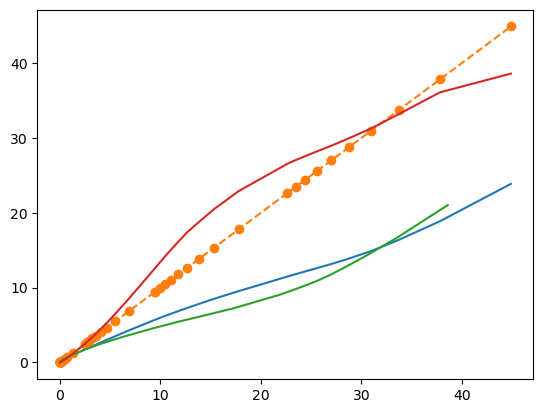

In [7]:
plt.plot(imerg_test_quantiles, ifs_test_quantiles)
plt.plot(imerg_test_quantiles, imerg_test_quantiles, 'o--')

plt.plot(imerg_training_quantiles, ifs_training_quantiles)

plt.plot(imerg_test_quantiles, np.interp(ifs_test_quantiles, ifs_training_quantiles, imerg_training_quantiles))

In [39]:
from dsrnngan.benchmarks import get_quantile_areas, get_quantiles_by_area, get_quantile_mapped_forecast

month_ranges = [[1,2], [3,4,5], [6,7,8,9], [10,11,12]]
quantile_threshold = 0.999

In [76]:
#Loop over many choices of gridding
    
import pickle

quantiles_by_area_dict = {}
corrected_fcst_dict = {'single_pixel': fcst_corrected_single_pixel}
for n_chunks in tqdm(range(1,13)):
    quantile_areas = get_quantile_areas(dates=list(quantile_training_dates), month_ranges=month_ranges, latitude_range=latitude_range, 
                                        longitude_range=longitude_range, num_lat_lon_chunks=n_chunks, hours=quantile_training_hours)
    quantiles_by_area_dict[n_chunks] = get_quantiles_by_area(quantile_areas, fcst_data=ifs_quantile_training_data, obs_data=imerg_quantile_training_data, 
                                            quantile_locs=quantile_locs)
    
    corrected_fcst_dict[n_chunks] = get_quantile_mapped_forecast(fcst=ifs_quantile_val_data, dates=quantile_val_dates, 
                                              hours=quantile_val_hours, month_ranges=month_ranges, 
                                              quantile_areas=quantile_areas, 
                                              quantiles_by_area=quantiles_by_area_dict[n_chunks])


    with open('tmp/corrected_fcst_dict.pkl', 'wb+') as ofh:
        pickle.dump(corrected_fcst_dict, ofh)

    with open('tmp/quantiles_by_area_dict.pkl', 'wb+') as ofh:
        pickle.dump(quantiles_by_area_dict, ofh)

 92%|█████████▏| 11/12 [12:10<01:06, 66.40s/it]


KeyboardInterrupt: 

In [81]:
corrected_fcst_dict[k].shape

(200, 271, 265)

In [93]:
hourly_historical_avg.shape

(270, 264)

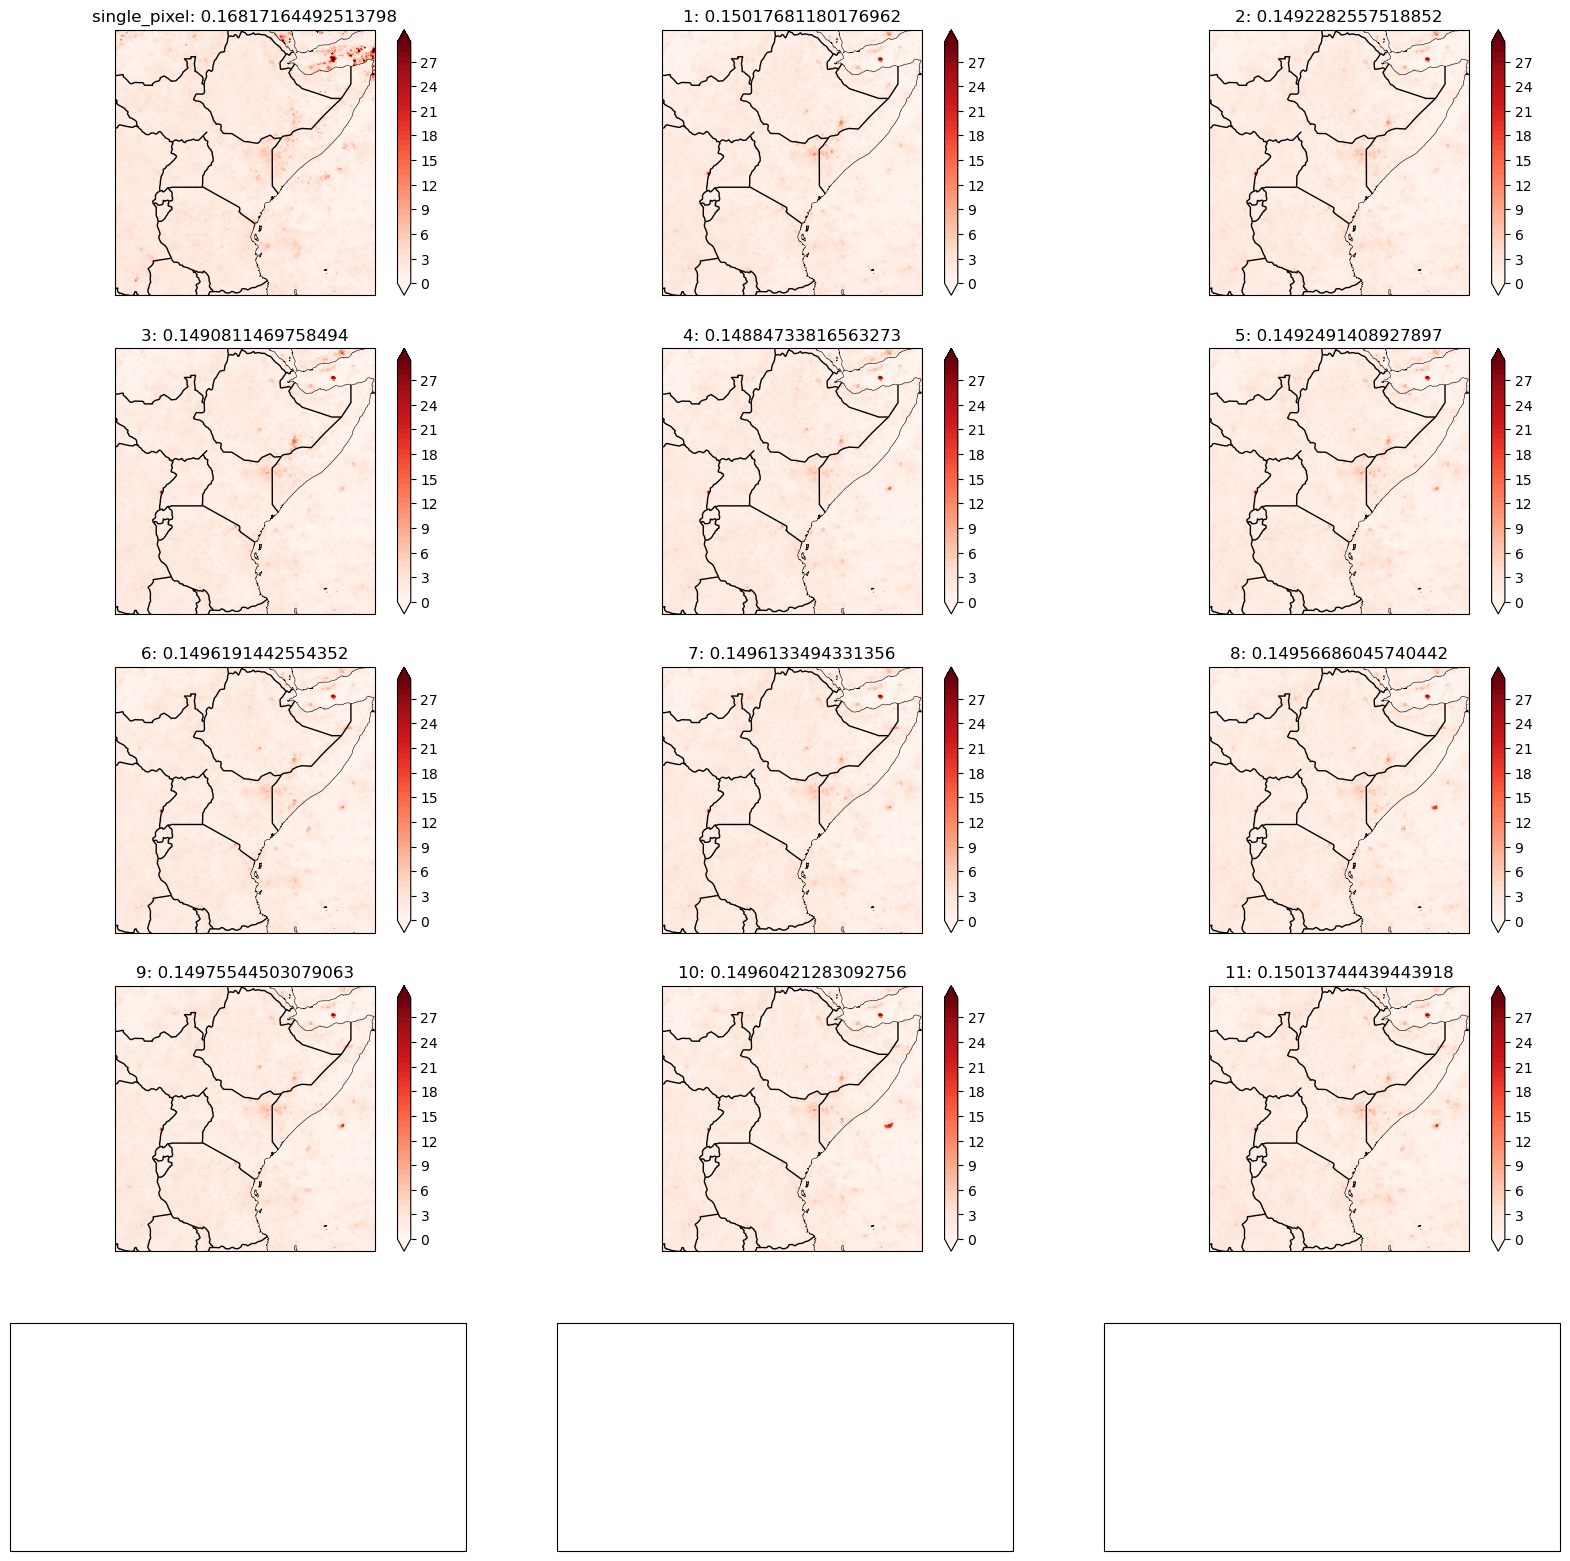

In [97]:
# Plot MAE for the forecasted regions

n_cols = 3
fig, ax = plt.subplots(int(len(corrected_fcst_dict.keys())/n_cols) + 1,n_cols, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(20,20))


max_level = 30
value_range = list(np.arange(0, max_level, max_level / 50))

for n, (k, v) in enumerate(corrected_fcst_dict.items()):
    
    row = int(n/n_cols)
    col = n - n_cols*row

    mae = np.mean(np.abs(corrected_fcst_dict[k] - imerg_quantile_val_data), axis=0)
    total_mae = np.nanmean(np.abs(corrected_fcst_dict[k] - imerg_quantile_val_data))
    # value_range=value_range, 
    im = plot_contourf(ax[row, col], mae[:-1,:-1] / hourly_historical_avg, 
                       title=k, lat_range=latitude_range, lon_range=longitude_range,  value_range=value_range)
    plt.colorbar(im, ax=ax[row, col])
    ax[row, col].set_title(f'{k}: {total_mae}')

plt.savefig('cgan_metrics/rmse.png')

In [11]:
import pickle

with open('/user/home/uz22147/repos/downscaling-cgan/mae_vals.pkl', 'rb') as ifh:

    mae_vals = pickle.load(ifh)

In [ ]:
y = [item[1] for item in mae_vals['mae_95']]
x = [item[0] for item in mae_vals['mae_95']] 
plt.plot(x,y)

In [11]:
from scipy.stats import gamma
(q_99pt9, q_99pt99) = np.quantile(truth_array, [0.999, 0.9999])
fitting_data = np.random.choice(truth_array.flatten(), size=int(4e6), replace=False)

truth_above_99pt99 = truth_array[np.where(truth_array >= q_99pt99)]
# fit_alpha, fit_loc, fit_beta=gamma.fit(fitting_data)

## Fit parametric distribution

In [12]:
import random

# Fitting using moments; perhaps would be better using mse distance but it is super slow
def get_gamma_parameters(data):
    mean = np.mean(data)
    variance = np.var(data)
    
    shape = mean*mean/variance
    scale = variance/mean
    
    return shape, scale

def get_lognormal_parameters(data):
    
    e_x = np.mean(data)
    var_x = np.var(data)
    
    var = np.log(1 + var_x / e_x**2)
    mu = np.log( e_x * np.exp(-0.5*var))
    
    return mu, var

# force integer values to get integer sample
shape, scale = get_gamma_parameters(truth_array)
gamma_sample_data = np.random.gamma(shape=shape, scale=scale, size=truth_array.size)

lognormal_mean, lognormal_variance = get_lognormal_parameters(truth_array)
lognormal_sample_data = np.random.lognormal(mean=lognormal_mean, sigma=np.sqrt(lognormal_variance), size=truth_array.size)
# sample_data = [i for i in gamma_random_sample(mean, variance, int(4e6))]


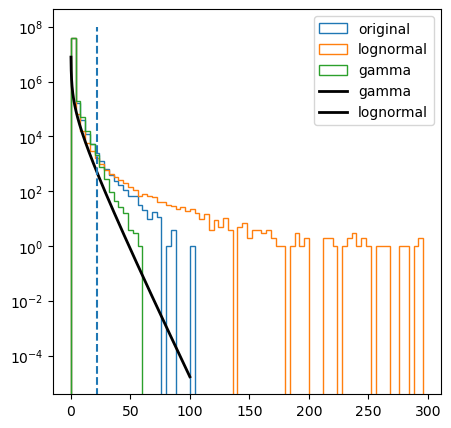

In [27]:
from scipy.stats import gamma, lognorm

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.hist(truth_array.flatten(), bins=np.arange(0,300,4), histtype= 'step', label='original', density=False)
ax.hist(lognormal_sample_data, histtype= 'step', label='lognormal', bins=np.arange(0,300,4), density=False)
ax.hist(gamma_sample_data, histtype= 'step', label='gamma', bins=np.arange(0,300,4), density=False)

# rv = gamma(shape, scale=scale)
# ax.plot(np.linspace(0,100, 1000), truth_array.size*rv.pdf(np.linspace(0,100, 1000)), 'k-', lw=2, label='gamma')

# rv = lognorm(lognormal_variance, scale=np.exp(lognormal_mean))
# ax.plot(np.linspace(0,100, 1000), truth_array.size*rv.pdf(np.linspace(0,100, 1000)), 'k-', lw=2, label='lognormal')

ax.vlines(q_99pt99, 0, 10**8, linestyles='--')
ax.set_yscale('log')
ax.legend()

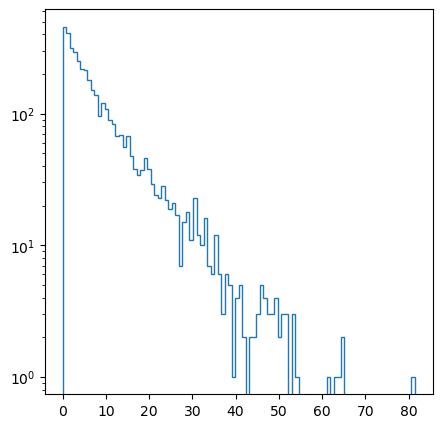

In [12]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

vals, bins, _ = ax.hist(truth_above_99pt99.flatten() - q_99pt99, bins=100, histtype= 'step', label='original', density=False)
ax.set_yscale('log')

In [45]:
from dsrnngan.benchmarks import get_exponential_tail_params

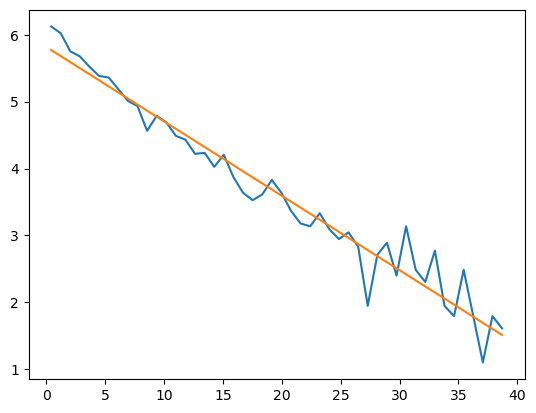

In [46]:
from sklearn.linear_model import LinearRegression

coef, intercept, (bin_centres, vals) = get_exponential_tail_params(truth_array, 0.9999)

plt.plot(bin_centres, np.log( vals))
plt.plot(bin_centres, [ intercept + coef*x  for x in bin_centres])